# Imports

In [1]:
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import xarray

In [2]:
from backend import loading_utils
from backend import data_paths
from backend import gauge_groups_utils
from backend import metrics_utils
from backend import evaluation_utils

In [3]:
# This flag should be set to True if you are loading GRDC daily streamflow data
# from a file that you got from the GRDC directly.
USE_RAW_GRDC_DATA = False
RESTART = True

# Metadata

## Gauge Groups

### Full Gauge Group

In [4]:
gauges = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(gauges)} gauges.')

There are 5678 gauges.


### GloFAS v3 Benchmarking Gauge Group

In [5]:
# Read GloFAS Metadata file.
glofas_metadata = loading_utils.load_glofas_metadata_file()
glofas_gauges = [gauge for gauge in glofas_metadata.index]

# Find gauge group intersection.
benchmarking_v3_gauges = list(set(gauges).intersection(glofas_gauges))
print(f'There are {len(benchmarking_v3_gauges)} v3 benchmarking gauges.')

There are 778 v3 benchmarking gauges.


### GloFAS v4 Benchmarking Gauge Group

In [6]:
# Read GloFAS Metadata file.
glofas_v4_metadata = loading_utils.load_glofas_v4_metadata_file()
glofas_v4_gauges = [gauge for gauge in glofas_v4_metadata.index]

# Find gauge group intersection.
benchmarking_v4_gauges = list(set(gauges).intersection(glofas_v4_gauges))
print(f'There are {len(benchmarking_v4_gauges)} v4 benchmarking gauges.')

There are 1144 v4 benchmarking gauges.


In [7]:
# gauges = [6984500, 6987050, 5708145, 6984800, 6998400, 6337400, 4150330, 6984700, 1591408, 4121400, 1837410]
# gauges = [f'GRDC_{gauge}' for gauge in gauges]
# benchmarking_v3_gauges = list(set(benchmarking_v3_gauges).intersection(set(gauges)))
# benchmarking_v4_gauges = list(set(benchmarking_v4_gauges).intersection(set(gauges)))
# gauges

## Validation Time Periods

### GloFAS v3

In [8]:
glofas_v3_validation_time_periods = {
    gauge: [
        glofas_metadata.loc[gauge, 'Validation_Start'],
        glofas_metadata.loc[gauge, 'Validation_End']
    ] for gauge in benchmarking_v3_gauges
}

glofas_v3_validation_time_periods.update(
    {
        gauge: None
        for gauge in gauges if gauge not in benchmarking_v3_gauges        
    }
)

In [9]:
# Ensure that all start and end dates are within the Google model window.
out_of_bounds_gauges = []
for gauge in benchmarking_v3_gauges:
  if datetime.datetime.strptime(glofas_v3_validation_time_periods[gauge][0], '%m/%d/%y %H:%M') < datetime.datetime(1980, 1, 1):
    out_of_bounds_gauges.append(gauge)
  if datetime.datetime.strptime(glofas_v3_validation_time_periods[gauge][1], '%m/%d/%y %H:%M') > datetime.datetime(2022, 1, 1):
    out_of_bounds_gauges.append(gauge)

print(f'There are {len(out_of_bounds_gauges)} gauges with dates that are out of bounds.')

There are 0 gauges with dates that are out of bounds.


### GloFAS v4

In [10]:
v4meta = loading_utils.load_glofas_v4_metadata_file()

def _get_v4_val_period(gauge):
  try:
    end_date = pd.to_datetime(v4meta.loc[gauge, 'Calib_start (Split Date)'].strip(), format='%d/%m/%Y %H:%M')
    start_date = pd.to_datetime(v4meta.loc[gauge, 'Start Obs'].strip(), format='%d/%m/%Y %H:%M')
    return [start_date, end_date]
  except:
    return None

glofas_v4_validation_time_periods = {gauge: _get_v4_val_period(gauge) for gauge in benchmarking_v4_gauges}

glofas_v4_validation_time_periods.update(
    {
        gauge: None
        for gauge in gauges if gauge not in benchmarking_v4_gauges        
    }
)

### Google Model

In [11]:
google_validation_time_periods = {
    gauge: ['2014-01-01', '2023-01-01'] for gauge in gauges
}

# Google Model Metrics

## Load Data: Google Model Runs

In [12]:
_EXPERIMENTS = data_paths.EXPERIMENTS

In [13]:
google_model_runs = loading_utils.load_all_experimental_model_runs(
  gauges=gauges,
  load_without_grdc=USE_RAW_GRDC_DATA
)

Working on experiment: kfold_splits


100%|█████████████████████████████████████████████████████████████████████████████████████| 5678/5678 [04:52<00:00, 19.41it/s]


Working on experiment: continent_splits


100%|█████████████████████████████████████████████████████████████████████████████████████| 5678/5678 [03:32<00:00, 26.71it/s]


Working on experiment: climate_splits


100%|█████████████████████████████████████████████████████████████████████████████████████| 5678/5678 [03:47<00:00, 24.94it/s]


Working on experiment: full_run


100%|█████████████████████████████████████████████████████████████████████████████████████| 5678/5678 [03:18<00:00, 28.63it/s]


In [14]:
# Count missing gauges per experiment.
for experiment in google_model_runs:
  missing_gauges = set(gauges) - set(google_model_runs[experiment].gauge_id.values)
  print(f'There are {len(missing_gauges)} (out of {len(gauges)}) missing gauges in experiemnt {experiment}.')

There are 0 (out of 5678) missing gauges in experiemnt kfold_splits.
There are 0 (out of 5678) missing gauges in experiemnt continent_splits.
There are 0 (out of 5678) missing gauges in experiemnt climate_splits.
There are 0 (out of 5678) missing gauges in experiemnt full_run.


## Load Data: GRDC Observation Data

In [15]:
if USE_RAW_GRDC_DATA:
  grdc_observation_data = loading_utils.load_grdc_data()
  unnormalized_grdc_observation_data = grdc_observation_data[metrics_utils.UNNORMALIZED_OBS_VARIABLE].rename(metrics_utils.OBS_VARIABLE)
  for experiment in google_model_runs.keys():
    google_model_runs[experiment] = xarray.merge(
        [google_model_runs[experiment], grdc_observation_data[metrics_utils.OBS_VARIABLE]])
  del grdc_observation_data

else:
  experiment = list(google_model_runs.keys())[0]
  unnormalized_grdc_observation_data = loading_utils.unnormalize_observation(
      normalized_discharge=google_model_runs[experiment][metrics_utils.OBS_VARIABLE])
  unnormalized_grdc_observation_data = unnormalized_grdc_observation_data.rename(metrics_utils.OBS_VARIABLE).sel(lead_time=0) 

## Metrics: 2014 - Present

In [16]:
metrics = metrics_utils.calculate_and_save_metrics_for_many_gagues_and_many_models(
    restart=RESTART,
    experiments=_EXPERIMENTS,
    ds=google_model_runs,
    gauges=gauges,
    sim_variable=metrics_utils.GOOGLE_VARIABLE,
    base_path=data_paths.PER_METRIC_GOOGLE_2014_HYDROGRAPH_METRICS_DIR,
    breakpoints_path=data_paths.PER_GAUGE_GOOGLE_2014_HYDROGRAPH_METRICS_DIR,
    time_periods=google_validation_time_periods,
)
metrics[_EXPERIMENTS[0]]['NSE'].replace(-np.inf, np.nan).describe()

Working on experiment: kfold_splits.


 22%|██████████████████▊                                                                  | 1254/5678 [03:57<37:17,  1.98it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

 31%|██████████████████████████▋                                                          | 1779/5678 [06:51<32:55,  1.97it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

Working on experiment: continent_splits.


 22%|██████████████████▊                                                                  | 1254/5678 [04:02<31:13,  2.36it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

Working on experiment: climate_splits.


 22%|██████████████████▊                                                                  | 1254/5678 [04:30<30:55,  2.38it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

Working on experiment: full_run.


 22%|██████████████████▊                                                                  | 1254/5678 [03:53<30:36,  2.41it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/notebooks/backend/metrics.py:728: RuntimeWarning: divide by zero encountered in scalar divide
  fhv = np.sum(sim - obs) / np.sum(obs)
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/num

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeli

,0,1,2,3,4,5,6,7
count,3.123000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.120000e+03
mean,-1.962734e+07,-2.102060e+07,-2.109913e+07,-2.019025e+07,-2.277043e+07,-3.070585e+07,-3.082518e+07,-8.610523e+07
std,1.096795e+09,1.174279e+09,1.178652e+09,1.127714e+09,1.271392e+09,1.714756e+09,1.721630e+09,4.809308e+09
min,-6.129308e+10,-6.560218e+10,-6.584650e+10,-6.300075e+10,-7.102749e+10,-9.579639e+10,-9.618045e+10,-2.686333e+11
25%,2.603827e-01,2.685189e-01,2.762704e-01,2.457662e-01,2.097277e-01,1.664594e-01,1.302200e-01,6.003166e-02
50%,6.167810e-01,6.085240e-01,5.941791e-01,5.677567e-01,5.311269e-01,4.907038e-01,4.350739e-01,3.855782e-01
75%,7.784371e-01,7.737810e-01,7.636446e-01,7.474180e-01,7.300884e-01,7.085401e-01,6.773115e-01,6.472294e-01
max,9.682986e-01,9.723056e-01,9.698213e-01,9.666545e-01,9.644245e-01,9.635150e-01,9.556777e-01,9.526724e-01


## Metrics: 1980 - Present

In [17]:
metrics = metrics_utils.calculate_and_save_metrics_for_many_gagues_and_many_models(
    restart=RESTART,
    experiments=_EXPERIMENTS,
    ds=google_model_runs,
    gauges=gauges,
    sim_variable=metrics_utils.GOOGLE_VARIABLE,
    base_path=data_paths.PER_METRIC_GOOGLE_1980_HYDROGRAPH_METRICS_DIR,
    breakpoints_path=data_paths.PER_GAUGE_GOOGLE_1980_HYDROGRAPH_METRICS_DIR,
    lead_times=[0]
)
metrics[_EXPERIMENTS[0]]['NSE'].replace(-np.inf, np.nan).describe()

Working on experiment: kfold_splits.


 22%|██████████████████▊                                                                  | 1254/5678 [01:42<07:22,  9.99it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

Working on experiment: continent_splits.


 22%|██████████████████▊                                                                  | 1254/5678 [01:46<07:04, 10.42it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

Working on experiment: climate_splits.


 22%|██████████████████▊                                                                  | 1254/5678 [01:39<06:28, 11.40it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

Working on experiment: full_run.


 22%|██████████████████▊                                                                  | 1254/5678 [01:39<06:52, 10.72it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

,0,1,2,3,4,5,6,7
count,5.568000e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,-1.935929e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.438662e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-1.073514e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.409881e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.583705e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.440574e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,9.647748e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Metrics: Glofas v3 Validation Period

In [18]:
metrics = metrics_utils.calculate_and_save_metrics_for_many_gagues_and_many_models(
    restart=RESTART,
    experiments=_EXPERIMENTS,
    ds=google_model_runs,
    gauges=benchmarking_v3_gauges,
    sim_variable=metrics_utils.GOOGLE_VARIABLE,
    base_path=data_paths.PER_METRIC_GOOGLE_v3_PERIOD_HYDROGRAPH_METRICS_DIR,
    breakpoints_path=data_paths.PER_GAUGE_GOOGLE_v3_PERIOD_HYDROGRAPH_METRICS_DIR,
    time_periods=glofas_v3_validation_time_periods,
)
metrics[_EXPERIMENTS[0]]['NSE'].replace(-np.inf, np.nan).describe()

Working on experiment: kfold_splits.


100%|███████████████████████████████████████████████████████████████████████████████████████| 778/778 [06:55<00:00,  1.87it/s]


Working on experiment: continent_splits.


100%|███████████████████████████████████████████████████████████████████████████████████████| 778/778 [07:01<00:00,  1.85it/s]


Working on experiment: climate_splits.


100%|███████████████████████████████████████████████████████████████████████████████████████| 778/778 [07:04<00:00,  1.83it/s]


Working on experiment: full_run.


100%|███████████████████████████████████████████████████████████████████████████████████████| 778/778 [06:59<00:00,  1.85it/s]


,0,1,2,3,4,5,6,7
count,748.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
unique,748.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
top,0.765223,0.771287,0.793771,0.784548,0.792908,0.806133,0.815005,0.812795
freq,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Metrics: Glofas v4 Validation Period

In [19]:
metrics = metrics_utils.calculate_and_save_metrics_for_many_gagues_and_many_models(
    restart=RESTART,
    experiments=_EXPERIMENTS,
    ds=google_model_runs,
    gauges=benchmarking_v4_gauges,
    sim_variable=metrics_utils.GOOGLE_VARIABLE,
    base_path=data_paths.PER_METRIC_GOOGLE_v4_PERIOD_HYDROGRAPH_METRICS_DIR,
    breakpoints_path=data_paths.PER_GAUGE_GOOGLE_v4_PERIOD_HYDROGRAPH_METRICS_DIR,
    time_periods=glofas_v4_validation_time_periods,
)
metrics[_EXPERIMENTS[0]]['NSE'].replace(-np.inf, np.nan).describe()

Working on experiment: kfold_splits.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1144/1144 [09:42<00:00,  1.96it/s]


Working on experiment: continent_splits.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1144/1144 [09:32<00:00,  2.00it/s]


Working on experiment: climate_splits.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1144/1144 [09:39<00:00,  1.97it/s]


Working on experiment: full_run.


100%|█████████████████████████████████████████████████████████████████████████████████████| 1144/1144 [09:31<00:00,  2.00it/s]


,0,1,2,3,4,5,6,7
count,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.00000,1013.000000
unique,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.00000,1013.000000
top,0.760589,0.744517,0.734028,0.724195,0.723198,0.723983,0.72511,0.714103
freq,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


## Delete Variables to Clear Memory

In [20]:
del google_model_runs

# GloFAS v3 Reanalysis

In [21]:
_EXPERIMENTS = [loading_utils.GLOFAS_REANALYSIS_VARIABLE_NAME]

## Load Data: GloFAS v3 All GRDC Gauges

In [22]:
glofas_v3_reanalysis_all_grdc_gauges = loading_utils.load_glofas_model_runs(
    gauges=gauges,
    reanalysis=True,
    all_grdc_gauges=True
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5678/5678 [03:48<00:00, 24.82it/s]


In [23]:
# Count missing gauges.
missing_gauges = len(gauges) - len(glofas_v3_reanalysis_all_grdc_gauges.gauge_id)
print(f'There are {missing_gauges} (out of {len(gauges)}) missing gauges in glofas runs.')

There are 1341 (out of 5678) missing gauges in glofas runs.


In [24]:
# Drop unused coordinates that might contain nans.
glofas_v3_reanalysis_all_grdc_gauges = glofas_v3_reanalysis_all_grdc_gauges.drop(
    [
        'surface',
        'latitude',
        'longitude',
        'valid_time',
    ]
)

In [25]:
# Merge everything into one large xarray.
# This xarray merge takes ... forever ...
merged_dataset_v3_reanalysis_all_grdc_gauges = xarray.merge(
    [glofas_v3_reanalysis_all_grdc_gauges.sel(lead_time=0), unnormalized_grdc_observation_data])

## Metrics: GloFAS v3 Validation Period

In [26]:
glofas_v3_reanalysis_benchmarking_gauges_metrics = metrics_utils.calculate_and_save_metrics_for_many_gagues_and_many_models(
    restart=RESTART,
    experiments=_EXPERIMENTS,
    ds={exp: merged_dataset_v3_reanalysis_all_grdc_gauges for exp in _EXPERIMENTS},
    gauges=benchmarking_v3_gauges,
    sim_variable=loading_utils.GLOFAS_REANALYSIS_VARIABLE_NAME,
    base_path=data_paths.PER_METRIC_GLOFAS_v3_REANALYSIS_BENCHMARKING_GAUGES_HYDROGRAPH_METRICS_DIR,
    breakpoints_path=data_paths.PER_GAUGE_GLOFAS_v3_REANALYSIS_BENCHMARKING_GAUGES_HYDROGRAPH_METRICS_DIR,
    time_periods=glofas_v3_validation_time_periods,
    lead_times=[0],
)
glofas_v3_reanalysis_benchmarking_gauges_metrics[_EXPERIMENTS[0]]['NSE'].describe()

Working on experiment: glofas_reanalysis.


100%|███████████████████████████████████████████████████████████████████████████████████████| 778/778 [00:56<00:00, 13.80it/s]


,0,1,2,3,4,5,6,7
count,727.000000,0,0,0,0,0,0,0
unique,727.000000,0,0,0,0,0,0,0
top,0.740325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Compare ECMWF-Calculated Metrics

In [27]:
metrics_comparison = pd.concat(
    [
        glofas_v3_reanalysis_benchmarking_gauges_metrics[loading_utils.GLOFAS_REANALYSIS_VARIABLE_NAME]['NSE'][0].rename('NSE').astype(float),
        glofas_v3_reanalysis_benchmarking_gauges_metrics[loading_utils.GLOFAS_REANALYSIS_VARIABLE_NAME]['KGE'][0].rename('KGE').astype(float),
        glofas_metadata['NSE_val'].loc[benchmarking_v3_gauges],
        glofas_metadata['KGE_val'].loc[benchmarking_v3_gauges],
    ], axis=1
)

metrics_comparison['NSE_diff'] = metrics_comparison['NSE'] - metrics_comparison['NSE_val']
metrics_comparison['KGE_diff'] = metrics_comparison['KGE'] - metrics_comparison['KGE_val']

metrics_comparison['KGE_abs_diff'] = np.abs(metrics_comparison['KGE_diff'])
metrics_comparison['NSE_abs_diff'] = np.abs(metrics_comparison['NSE_diff'])

metrics_comparison.describe()

,NSE,KGE,NSE_val,KGE_val,NSE_diff,KGE_diff,KGE_abs_diff,NSE_abs_diff
count,727.000000,727.000000,750.000000,750.000000,727.000000,727.000000,727.000000,727.000000
mean,-2.990679,-0.223711,-2.509607,0.279706,-0.419028,-0.496443,0.565362,1.156817
std,16.369558,4.739398,15.465337,0.898384,7.859032,4.588414,4.580422,7.784609
min,-315.134027,-85.703986,-355.077539,-6.634952,-160.736090,-86.271095,0.000012,0.000071
25%,-0.622307,-0.009341,-0.760158,0.211549,-0.071128,-0.210958,0.037281,0.050792
50%,0.412536,0.570429,0.329977,0.605103,0.035436,-0.045373,0.095131,0.143773
75%,0.674917,0.767177,0.632416,0.779611,0.206174,0.031608,0.238393,0.401109
max,0.938989,0.952154,0.940140,0.964835,39.943511,2.187770,86.271095,160.736090


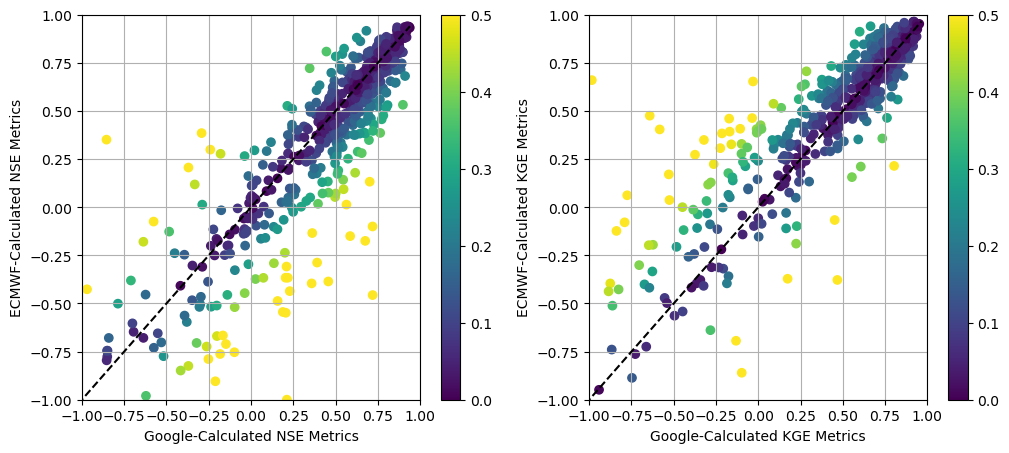

In [28]:
# Plot the comparison between metrics.
def _plot_comparison(
    ours: pd.Series, 
    theirs: pd.Series, 
    metric: str,
    ax: plt.Axes,
):

  diffs = np.abs(ours - theirs)
  xmin = min([min(ours), min(theirs)])
  xmax = max([max(ours), max(theirs)])

  pcm = ax.scatter(
      ours, 
      theirs, 
      c=np.abs(diffs.values), 
      vmin=0, 
      vmax=0.5
  )
  ax.set_xlabel(f'Google-Calculated {metric} Metrics')
  ax.set_ylabel(f'ECMWF-Calculated {metric} Metrics')

  ax.plot([xmin, xmax], [xmin, xmax], 'k--')

  ax.set_xlim(evaluation_utils.METRICS_AXIS_LIMITS[metric])
  ax.set_ylim(evaluation_utils.METRICS_AXIS_LIMITS[metric])
  ax.grid()

  fig.colorbar(pcm, ax=ax)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, metric in enumerate(['NSE', 'KGE']):
  _plot_comparison(
      ours=metrics_comparison[metric],
      theirs=metrics_comparison[f'{metric}_val'],
      metric=metric,
      ax=axes[i],
  )

## Metrics: 1980 - Present

In [29]:
metrics = metrics_utils.calculate_and_save_metrics_for_many_gagues_and_many_models(
    restart=RESTART,
    experiments=_EXPERIMENTS,
    ds={exp: merged_dataset_v3_reanalysis_all_grdc_gauges for exp in _EXPERIMENTS},
    gauges=gauges,
    sim_variable=loading_utils.GLOFAS_REANALYSIS_VARIABLE_NAME,
    base_path=data_paths.PER_METRIC_GLOFAS_v3_REANALYSIS_ALL_GRDC_GAUGES_1980_HYDROGRAPH_METRICS_DIR,
    breakpoints_path=data_paths.PER_GAUGE_GLOFAS_v3_REANALYSIS_ALL_GRDC_GAUGES_1980_HYDROGRAPH_METRICS_DIR,
    lead_times=[0]
)
metrics[_EXPERIMENTS[0]]['NSE'].describe()

Working on experiment: glofas_reanalysis.


 22%|██████████████████▊                                                                  | 1253/5678 [01:18<05:40, 12.99it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

,0,1,2,3,4,5,6,7
count,4252.00000,0,0,0,0,0,0,0
unique,4252.00000,0,0,0,0,0,0,0
top,-79.24515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Metrics: 2014 - Present

In [30]:
metrics = metrics_utils.calculate_and_save_metrics_for_many_gagues_and_many_models(
    restart=RESTART,
    experiments=_EXPERIMENTS,
    ds={exp: merged_dataset_v3_reanalysis_all_grdc_gauges for exp in _EXPERIMENTS},
    gauges=gauges,
    sim_variable=loading_utils.GLOFAS_REANALYSIS_VARIABLE_NAME,
    base_path=data_paths.PER_METRIC_GLOFAS_v3_REANALYSIS_ALL_GRDC_GAUGES_2014_HYDROGRAPH_METRICS_DIR,
    breakpoints_path=data_paths.PER_GAUGE_GLOFAS_v3_REANALYSIS_ALL_GRDC_GAUGES_2014_HYDROGRAPH_METRICS_DIR,
    time_periods=google_validation_time_periods,
    lead_times=[0]
)
metrics[_EXPERIMENTS[0]]['NSE'].describe()

Working on experiment: glofas_reanalysis.


 22%|██████████████████▊                                                                  | 1254/5678 [00:33<04:17, 17.21it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

 45%|██████████████████████████████████████▍                                              | 2565/5678 [03:09<07:29,  6.93it/s]/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/gsnearing/miniconda3/envs/global-modeling-paper/lib/python3.11/site-packages/numpy/lib/function_base.py:

,0,1,2,3,4,5,6,7
count,2435.0,0,0,0,0,0,0,0
unique,2426.0,0,0,0,0,0,0,0
top,-inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# GloFAS v4 Reanalysis

## Load Data: GloFAS v4 Benchmarking Gauges

In [31]:
glofas_v4_reanalysis_benchmarking_gauges = loading_utils.load_glofas_model_runs(
    gauges=benchmarking_v4_gauges,
    v4=True,
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1144/1144 [00:28<00:00, 40.11it/s]


In [32]:
# Count missing gauges.
missing_gauges = len(benchmarking_v4_gauges) - len(glofas_v4_reanalysis_benchmarking_gauges.gauge_id)
print(f'There are {missing_gauges} (out of {len(benchmarking_v4_gauges)}) missing gauges in glofas runs.')

There are 43 (out of 1144) missing gauges in glofas runs.


In [33]:
# Drop unused coordinates that might contain nans.
glofas_v4_reanalysis_benchmarking_gauges = glofas_v4_reanalysis_benchmarking_gauges.drop(
    [
        'latitude',
        'longitude',
    ]
)

In [34]:
# Merge everything into one large xarray.
# This xarray merge takes ... forever ...
merged_dataset_v4_reanalysis_benchmarking_gauges = xarray.merge(
    [glofas_v4_reanalysis_benchmarking_gauges, unnormalized_grdc_observation_data])

# For the reanalysis, only use the nowcast.
merged_dataset_v4_reanalysis_benchmarking_gauges = merged_dataset_v4_reanalysis_benchmarking_gauges.sel(lead_time=[0])

## Metrics: GloFAS v4 Benchmarking Period

In [36]:
glofas_v4_reanalysis_benchmarking_gauges_metrics = metrics_utils.calculate_and_save_metrics_for_many_gagues_and_many_models(
    restart=RESTART,
    experiments=_EXPERIMENTS,
    ds={exp: merged_dataset_v4_reanalysis_all_grdc_gauges for exp in _EXPERIMENTS},
    gauges=benchmarking_v4_gauges,
    sim_variable=loading_utils.GLOFAS_REANALYSIS_VARIABLE_NAME,
    base_path=data_paths.PER_METRIC_GLOFAS_v4_REANALYSIS_BENCHMARKING_GAUGES_HYDROGRAPH_METRICS_DIR,
    breakpoints_path=data_paths.PER_GAUGE_GLOFAS_v4_REANALYSIS_BENCHMARKING_GAUGES_HYDROGRAPH_METRICS_DIR,
    time_periods=glofas_v4_validation_time_periods,
    lead_times=[0],
)
glofas_v4_reanalysis_benchmarking_gauges_metrics[_EXPERIMENTS[0]]['NSE'].describe()

NameError: name 'merged_dataset_v4_reanalysis_all_grdc_gauges' is not defined

In [37]:
x = pd.concat([
    glofas_v3_reanalysis_benchmarking_gauges_metrics['glofas_reanalysis']['NSE'][0], 
    glofas_v4_benchmarking_gauges_metrics['glofas_reanalysis']['NSE'][0].rename(1),
    v4meta['KGE_GloFASv4_all_obs'].loc[benchmarking_v4_gauges].rename(2)
    ], axis=1).dropna()

fig, ax = plt.subplots(1, 1)
evaluation_utils.plot_cdf(
    scores=x[0].values,
    ax=ax,
    xlabel='NSE',
    label='v3',
)

evaluation_utils.plot_cdf(
    scores=x[1].values,
    ax=ax,
    xlabel='NSE',
    label='v4',
    xlim=[-1,1]
)

# evaluation_utils.plot_cdf(
#     scores=x[2].values,
#     ax=ax,
#     xlabel='NSE',
#     label='v4 - whole period',
#     xlim=[-1,1]
# )
ax.grid()

NameError: name 'glofas_v4_benchmarking_gauges_metrics' is not defined

In [ ]:
x = pd.concat([
    glofas_v3_reanalysis_benchmarking_gauges_metrics['glofas_reanalysis']['KGE'][0], 
    glofas_v4_benchmarking_gauges_metrics['glofas_reanalysis']['KGE'][0].rename(1),
    v4meta['KGE_GloFASv4_all_obs'].loc[benchmarking_v4_gauges].rename(2)
    ], axis=1).dropna()

fig, ax = plt.subplots(1, 1)
evaluation_utils.plot_cdf(
    scores=x[0].values,
    ax=ax,
    xlabel='KGE',
    label='v3',
)

evaluation_utils.plot_cdf(
    scores=x[1].values,
    ax=ax,
    xlabel='KGE',
    label='v4',
    xlim=[-1,1]
)

evaluation_utils.plot_cdf(
    scores=x[2].values,
    ax=ax,
    xlabel='KGE',
    label='v4 - whole period',
    xlim=[-1,1]
)
ax.grid()

In [ ]:
fig, ax = plt.subplots(1, 1)
evaluation_utils.plot_cdf(
    scores=x[0].values,
    ax=ax,
    xlabel='NSE',
    label='v3',
)

evaluation_utils.plot_cdf(
    scores=x[1].values,
    ax=ax,
    xlabel='NSE',
    label='v4',
    xlim=[-1,1]
)
ax.grid()

### Compare ECMWF-Calculated Metrics

In [ ]:
v4_metrics_comparison = pd.concat(
    [
        glofas_v4_benchmarking_gauges_metrics[loading_utils.GLOFAS_REANALYSIS_VARIABLE_NAME]['NSE'][0].rename('NSE').astype(float),
        glofas_v4_benchmarking_gauges_metrics[loading_utils.GLOFAS_REANALYSIS_VARIABLE_NAME]['KGE'][0].rename('KGE').astype(float),
        v4meta['KGE3_GloFASv4_only_Calib_period'].loc[benchmarking_v4_gauges],
        v4meta['KGE_GloFASv4_all_obs'].loc[benchmarking_v4_gauges],
    ], axis=1
)

# v4_metrics_comparison['NSE_diff'] = v4_metrics_comparison['NSE'] - v4_metrics_comparison['NSE_val']
v4_metrics_comparison['KGE_diff'] = v4_metrics_comparison['KGE'] - v4_metrics_comparison['KGE_GloFASv4_all_obs']

v4_metrics_comparison['KGE_abs_diff'] = np.abs(v4_metrics_comparison['KGE_diff'])
# v4_metrics_comparison['NSE_abs_diff'] = np.abs(v4_metrics_comparison['NSE_diff'])

v4_metrics_comparison.describe()

# Plot Hydrograph Metric CDFs

In [38]:
%load_ext autoreload
%autoreload 2

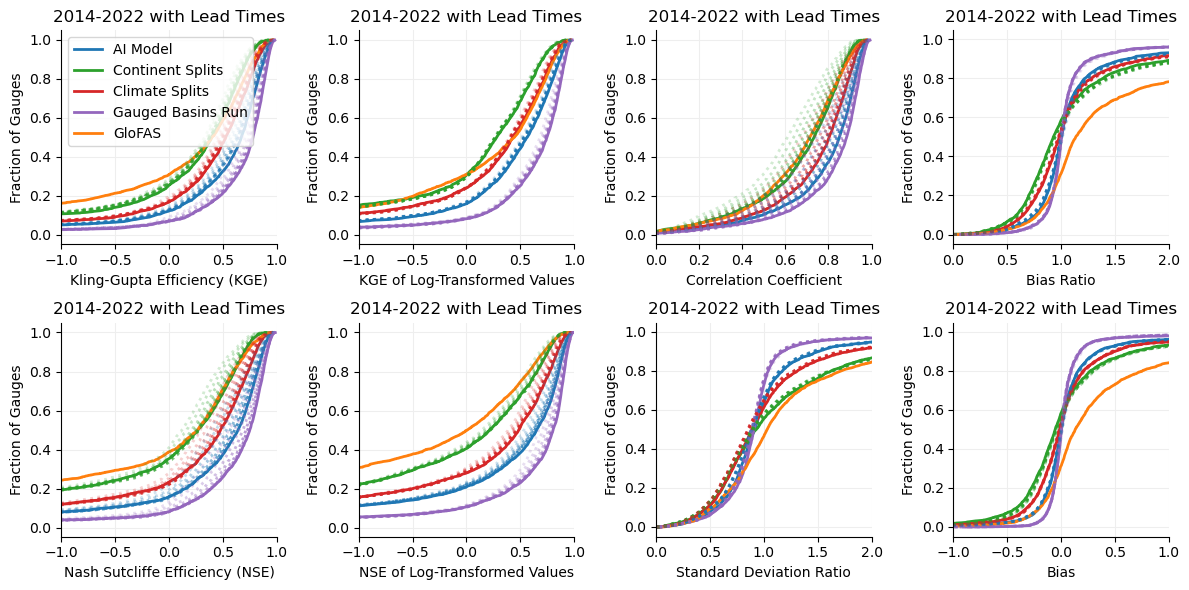

In [72]:
evaluation_utils.hydrograph_metrics_cdf_plots(
    time_period_identifier='2014',
    title='2014-2022 with Lead Times',
    lead_times=list(range(8))
)
evaluation_utils.save_figure(data_paths.HYDROGRAPH_METRICS_WITH_LEAD_TIMES_CDFS_FILENAME)

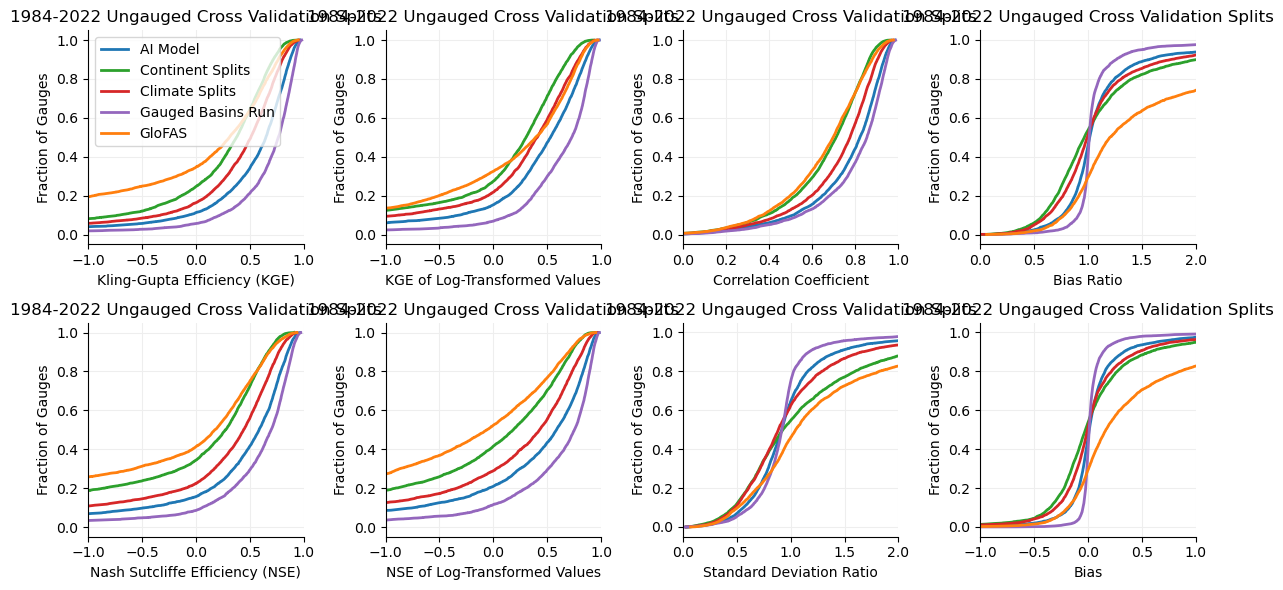

In [73]:
evaluation_utils.hydrograph_metrics_cdf_plots(
    time_period_identifier='1980',
    title='1984-2022 Ungauged Cross Validation Splits',
    lead_times=[0]
)
evaluation_utils.save_figure(data_paths.HYDROGRAPH_METRICS_GLOFAS_UNGAUGED_CDFS_FILENAME)

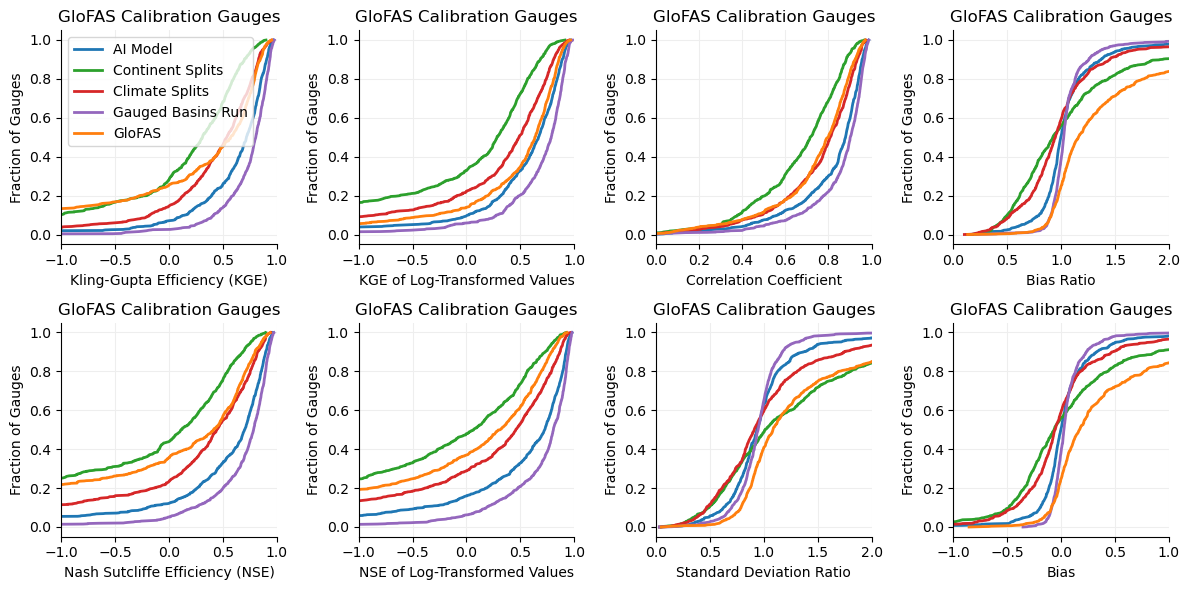

In [79]:
evaluation_utils.hydrograph_metrics_cdf_plots(
    time_period_identifier='v3_benchmarking',
    title='GloFAS Calibration Gauges',
    lead_times=[0]
)
evaluation_utils.save_figure(data_paths.HYDROGRAPH_METRICS_GLOFAS_GAUGED_CDFS_FILENAME)